In [1]:
from qcportal import PortalClient

import numpy as np
from matplotlib import pyplot as plt

ml_client = PortalClient(address="https://ml.qcarchive.molssi.org") # This is the ML Dataset QCArchive address for SPICE
off_client = PortalClient("https://api.qcarchive.molssi.org:443")

In [2]:
from openff.qcsubmit.factories import OptimizationDatasetFactory
from openff.qcsubmit.results import OptimizationResultCollection
from openff.qcsubmit.datasets import OptimizationDataset
from openff.toolkit import Molecule, Quantity, unit
from openff.qcsubmit.common_structures import Metadata, MoleculeAttributes
from openff.qcsubmit.procedures import GeometricProcedure

In [3]:
import logging
# # suppress stereochemistry warnings
logging.getLogger("openff").setLevel(logging.ERROR)

from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')

from tqdm import tqdm

In [4]:
original_ds = ml_client.get_dataset('singlepoint',dataset_name =  'SPICE DES Monomers Single Points Dataset v1.1')

In [5]:
original_entries = [entry for entry in tqdm(original_ds.iterate_entries())]

18700it [00:11, 1595.47it/s]


In [6]:
names,counts = np.unique(['-'.join(x.split('-')[:-1]) for x in original_ds.entry_names],return_counts=True)
print(np.all(counts == 50))
n_conf_dict = dict(zip(names, counts))

True


In [7]:
dataset = OptimizationDataset(
    dataset_name="SPICE DES370k Monomers Partial Relaxation Dataset v4.0",
    dataset_tagline="B3LYP-D3BJ/DZVP partial relaxation of each conformer of each molecule in the DES370k Monomers subset of SPICE.",
    description=(
        "A dataset containing all entries of the `DES370k Monomers` subset of the SPICE dataset, \n"
        "optimized for until the energy converges within 1e-4 Ha, at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). \n"  
        "Intended to be used to expand SPICE to include geometries closer to the QM local minimum. \n"
        "Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/des370k.\n\n"
    ),
    
)
dataset.metadata.submitter = "amcisaac"
dataset.metadata.long_description_url = ("https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-03-12-SPICE-DES370k-Monomers-Partial-Relaxation-Dataset-v4.0") 

In [8]:
dataset.optimization_procedure = GeometricProcedure(program='geometric', 
                                                      maxiter=300,
                                                      convergence_set = 'CUSTOM',
                                                      converge = ['energy', '1e-4', 'grms', '1', 'gmax', '1', 'drms', '1', 'dmax', '1'],
                                                     )

In [9]:
dataset.qc_specifications

{'default': QCSpec(method='B3LYP-D3BJ', basis='DZVP', program='psi4', spec_name='default', spec_description='Standard OpenFF optimization quantum chemistry specification.', store_wavefunction=<WavefunctionProtocolEnum.none: 'none'>, implicit_solvent=None, maxiter=200, scf_properties=[<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>, <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>, <SCFProperties.MayerIndices: 'mayer_indices'>], keywords={})}

In [10]:
dataset.optimization_procedure

GeometricProcedure(program='geometric', coordsys='dlc', enforce=0.0, epsilon=1e-05, reset=True, qccnv=False, molcnv=False, check=0, trust=0.1, tmax=0.3, maxiter=300, convergence_set='CUSTOM', constraints={}, converge=['energy', '1e-4', 'grms', '1', 'gmax', '1', 'drms', '1', 'dmax', '1'])

In [11]:
# Add molecules this way to preserve exact geometry from ML QCArchive in case we want it.
# Names will be the original QCA name, augmented by the number of conformers
# So brcbr-0 in the original SPICE Dipeptides will become brcbr-50 here for optimization.
for entry in tqdm(original_entries):
    base_name = '-'.join(entry.name.split('-')[:-1])
    conf_id = int(entry.name.split('-')[-1])
    n_confs = n_conf_dict[base_name] # Will always be 50 for this dataset
    dataset.add_molecule(index=base_name + '-{}'.format(conf_id + n_confs),molecule=None,initial_molecules = [entry.molecule],attributes=MoleculeAttributes.from_openff_molecule(Molecule.from_qcschema(entry.molecule,allow_undefined_stereo=True)))

100%|██████████| 18700/18700 [00:59<00:00, 311.82it/s]


In [12]:

# Check that the molecules are identical
opt_hashes = {
        rec.molecule.get_hash() for rec in original_entries
    }

new_hashes = {
    qcemol.identifiers.molecule_hash
    for moldata in dataset.dataset.values()
    for qcemol in moldata.initial_molecules
}

print('Molecules are the same? ',opt_hashes==new_hashes)

Molecules are the same?  True


# Analyze dataset

In [13]:
_,n_confs = np.unique(['-'.join(x.split('-')[:-1]) for x in original_ds.entry_names],return_counts=True) # conformers are all added as separate molecules so do the count this way

n_heavy_atoms = np.array(
    [mol.to_rdkit().GetNumHeavyAtoms() for mol in dataset.molecules]
)

masses = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in dataset.molecules
])

elements = set(
    atom.symbol
    for mol in dataset.molecules
    for atom in mol.atoms
)

unique_charges = [str(charge) for charge in sorted(set([
    mol.total_charge.m_as(unit.elementary_charge)
    for mol in dataset.molecules
]))]

from collections import Counter

print("# heavy atoms")
counts = Counter(n_heavy_atoms)
for n_heavy in sorted(counts):
    print(f"{str(n_heavy):>3}: {counts[n_heavy]}")


# heavy atoms
  1: 250
  2: 700
  3: 1250
  4: 2600
  5: 3900
  6: 4450
  7: 2900
  8: 1700
  9: 500
 10: 200
 11: 150
 12: 100


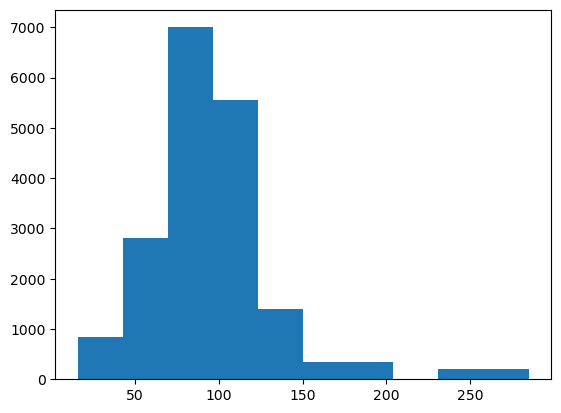

In [14]:
from matplotlib import pyplot as plt
plt.figure()
plt.hist(masses)
plt.show()

In [15]:
print('* Name: {}'.format(dataset.dataset_name))
print('* Number of unique molecules: {}'.format(dataset.n_molecules))
print('* Number of conformers: {}'.format(dataset.n_records))
print('* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(n_confs),np.mean(n_confs),max(n_confs)))
print('* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(masses),np.mean(masses),max(masses)))
print('* Charges: {}'.format(' '.join(unique_charges)))

print("## Metadata")
print(f"* Elements: {{{', '.join(dataset.metadata.dict()['elements'])}}}")

def print_field(od, field): print(f"  * {field}: {od[field]}")

fields = ["basis", "implicit_solvent", "keywords", "maxiter", "method", "program"]
for spec, obj in dataset.qc_specifications.items():
    od = obj.dict()
    print("* Spec:", spec)
    for field in fields:
        print_field(od, field)
    print("  * SCF properties:")
    for field in od["scf_properties"]:
        print(f"    * {field}")

* Name: SPICE DES370k Monomers Partial Relaxation Dataset v4.0
* Number of unique molecules: 376
* Number of conformers: 18700
* Number of conformers (min, mean, max): 50.00, 50.00, 50.00
* Molecular weight (min, mean, max): 16.04, 95.89, 284.78
* Charges: -1.0 0.0 1.0
## Metadata
* Elements: {O, P, Br, H, Cl, N, C, S, F, I}
* Spec: default
  * basis: DZVP
  * implicit_solvent: None
  * keywords: {}
  * maxiter: 200
  * method: B3LYP-D3BJ
  * program: psi4
  * SCF properties:
    * dipole
    * quadrupole
    * wiberg_lowdin_indices
    * mayer_indices


In [16]:
dataset.metadata.long_description=(("A dataset containing all entries of the `DES370k Monomers` subset of the SPICE dataset, \n"
        "optimized for until the energy converges within 1e-4 Ha, at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). \n"  
        "Intended to be used to expand SPICE to include geometries closer to the QM local minimum. \n"
        "Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/des370k.\n\n"
        "Dataset information:\n"
        "* Number of unique molecules: {}\n"
        "* Number of conformers: {}\n"
        "* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Charges: {}\n"
        "* Elements: {}\n"
        "* Submission directory: {}".format(dataset.n_molecules,dataset.n_records,min(n_confs),np.mean(n_confs),max(n_confs),min(masses),np.mean(masses),max(masses),' '.join(unique_charges),f"{{{', '.join(dataset.metadata.dict()['elements'])}}}",dataset.metadata.long_description_url)
        ))

dataset.description = dataset.metadata.long_description

In [17]:
print(dataset.description)

A dataset containing all entries of the `DES370k Monomers` subset of the SPICE dataset, 
optimized for until the energy converges within 1e-4 Ha, at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). 
Intended to be used to expand SPICE to include geometries closer to the QM local minimum. 
Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/des370k.

Dataset information:
* Number of unique molecules: 376
* Number of conformers: 18700
* Number of conformers (min, mean, max): 50.00, 50.00, 50.00
* Molecular weight (min, mean, max): 16.04, 95.89, 284.78
* Charges: -1.0 0.0 1.0
* Elements: {O, P, Br, H, Cl, N, C, S, F, I}
* Submission directory: https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-03-12-SPICE-DES370k-Monomers-Partial-Relaxation-Dataset-v4.0


In [18]:
print(dataset.metadata.long_description)

A dataset containing all entries of the `DES370k Monomers` subset of the SPICE dataset, 
optimized for until the energy converges within 1e-4 Ha, at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). 
Intended to be used to expand SPICE to include geometries closer to the QM local minimum. 
Detailed description on how the original dataset is generated can be found at https://github.com/openmm/spice-dataset/tree/main/des370k.

Dataset information:
* Number of unique molecules: 376
* Number of conformers: 18700
* Number of conformers (min, mean, max): 50.00, 50.00, 50.00
* Molecular weight (min, mean, max): 16.04, 95.89, 284.78
* Charges: -1.0 0.0 1.0
* Elements: {O, P, Br, H, Cl, N, C, S, F, I}
* Submission directory: https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2025-03-12-SPICE-DES370k-Monomers-Partial-Relaxation-Dataset-v4.0


In [19]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file('dataset.smi', 'smi')
dataset.visualize("dataset.pdf", columns=8)